<a href="https://colab.research.google.com/github/PhilippMatthes/diplom/blob/master/src/shl-deep-learning-validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Get needed auxiliary files for colab
!git clone https://github.com/philippmatthes/diplom
%cd /content/diplom/src
!mkdir shl-dataset
!wget -nc -O shl-dataset/challenge-2020-validation.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-validation.zip

Cloning into 'diplom'...
remote: Enumerating objects: 1498, done.
remote: Counting objects: 100% (835/835), done.
remote: Compressing objects: 100% (538/538), done.
remote: Total 1498 (delta 410), reused 667 (delta 257), pack-reused 663
Receiving objects: 100% (1498/1498), 33.69 MiB | 21.06 MiB/s, done.
Resolving deltas: 100% (786/786), done.
/content/diplom/src
--2021-08-10 08:01:53--  http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-validation.zip
Resolving www.shl-dataset.org (www.shl-dataset.org)... 37.187.125.22
Connecting to www.shl-dataset.org (www.shl-dataset.org)|37.187.125.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3263492796 (3.0G) [application/zip]
Saving to: ‘shl-dataset/challenge-2020-validation.zip’

shl-dataset/challen 100%[===================>]   3.04G  9.59MB/s    in 7m 32s  

2021-08-10 08:09:26 (6.88 MB/s) - ‘shl-dataset/challenge-2020-validation.zip’ saved [3263492796/3263492796]



In [2]:
# Switch to src dir and select tensorflow
%cd /content/diplom/src
%tensorflow_version 2.x

/content/diplom/src


In [3]:
# Define all datasets to train our model on

from pathlib import Path

DATASET_DIR = Path('shl-dataset/challenge-2020-validation.zip')

In [4]:
from tensorflow import keras

# Check that we can use our GPU, to not wait forever during training
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10232706267099369440, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16183459840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9181079785422368877
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [5]:
from tools.dataset import load_zipped_shl_dataset

from tqdm import tqdm

dataset = load_zipped_shl_dataset(DATASET_DIR, tqdm=tqdm, subdir_in_zip='validation')

Extracting shl-dataset/challenge-2020-validation.zip: 100%|██████████| 89/89 [02:04<00:00,  1.40s/it]


Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done
Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done
Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done
Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


In [7]:
import numpy as np

# Check that we don't have NaNs in our dataset
assert not np.isnan(dataset.acc_mag).any()
assert not np.isnan(dataset.mag_mag).any()
assert not np.isnan(dataset.gyr_mag).any()

In [8]:
import joblib

from sklearn.preprocessing import PowerTransformer

acc_scaler = joblib.load('models/acc-scaler.joblib')
mag_scaler = joblib.load('models/mag-scaler.joblib')
gyr_scaler = joblib.load('models/gyr-scaler.joblib')

acc_mag_scaled = acc_scaler.transform(dataset.acc_mag)
mag_mag_scaled = mag_scaler.transform(dataset.mag_mag)
gyr_mag_scaled = gyr_scaler.transform(dataset.gyr_mag)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PowerTransformer from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
import numpy as np

# Prepare testing data
X = np.stack([
    acc_mag_scaled,
    mag_mag_scaled, 
    gyr_mag_scaled,
], axis=2)

del acc_mag_scaled
del mag_mag_scaled
del gyr_mag_scaled

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(dataset.labels), y=dataset.labels)
class_weights = dict(zip(np.unique(dataset.labels), class_weights)) # Keras adaption
class_weights[0] = 0 # NULL label
class_weights

{0: 0,
 1: 0.6030878163231105,
 2: 0.688732057416268,
 3: 6.484009009009009,
 4: 1.4950664727877025,
 5: 0.8787851037851038,
 6: 1.960035403050109,
 7: 0.8249942686840899,
 8: 0.8287943344081069}

In [21]:
model = keras.models.load_model(Path('models/shl-resnet'))

y_pred_args = model.predict(X)
print(y_pred_args, dataset.labels)


[[1.38615608e-09 5.91114044e-01 1.79577082e-01 ... 7.94821382e-02
  7.85923600e-02 1.24660451e-02]
 [2.46449427e-13 4.56631155e-04 5.80977574e-02 ... 2.76897656e-04
  1.24262777e-04 2.81254965e-04]
 [6.95376697e-26 3.31789095e-15 8.33010461e-09 ... 1.44571939e-14
  1.55079688e-14 1.79133408e-14]
 ...
 [8.60083445e-12 1.08758636e-01 8.06532323e-01 ... 1.42822589e-03
  8.23953282e-03 5.08725345e-02]
 [1.59660317e-13 1.02376740e-03 7.54641652e-01 ... 3.10350297e-04
  9.10254093e-05 1.79296511e-03]
 [7.79248302e-13 4.24337298e-01 1.22704491e-01 ... 2.35605825e-04
  2.19185039e-01 2.32537016e-01]] [3 3 3 ... 2 2 2]


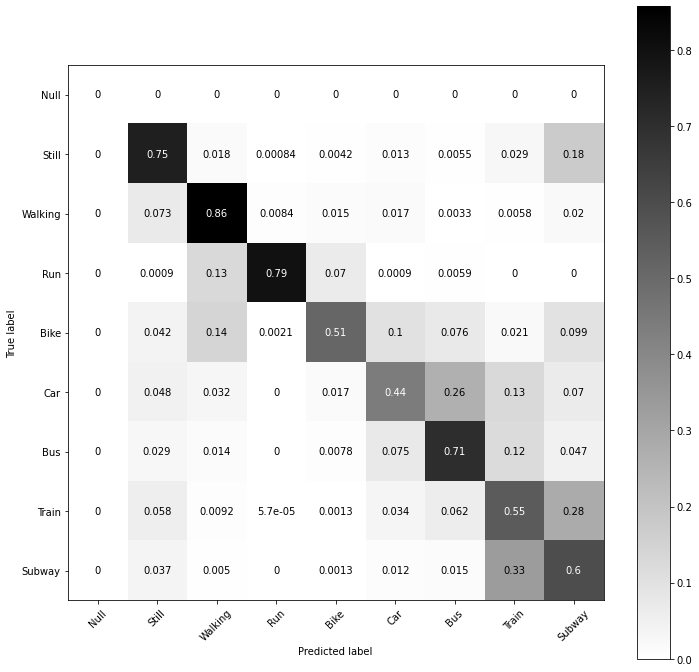

In [28]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tools.plots import plot_confusion_matrix
from tools.dataset import shl_dataset_label_order

y_pred = np.argmax(y_pred_args, axis=1)
y_true = dataset.labels

fig, ax = plt.subplots(1)
fig.set_size_inches(12, 12)
cm = confusion_matrix(y_true, y_pred, labels=range(9), normalize='true')
disp = ConfusionMatrixDisplay(cm, shl_dataset_label_order)
disp.plot(cmap='binary', xticks_rotation=45, ax=ax)